In [1]:
import pandas as pd
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
file_path = "dataset/preprocessed_file.csv"
data = pd.read_csv(file_path)

Perform basic data exploration

In [8]:
data.info()
data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1008748 entries, 0 to 1008747
Data columns (total 11 columns):
 #   Column         Non-Null Count    Dtype  
---  ------         --------------    -----  
 0   ts             1008748 non-null  object 
 1   id.orig_h      1008748 non-null  object 
 2   id.resp_h      1008748 non-null  object 
 3   proto          1008748 non-null  object 
 4   duration       1008748 non-null  float64
 5   conn_state     1008748 non-null  object 
 6   history        991327 non-null   object 
 7   orig_pkts      1008748 non-null  int64  
 8   orig_ip_bytes  1008748 non-null  int64  
 9   resp_pkts      1008748 non-null  int64  
 10  label          1008748 non-null  object 
dtypes: float64(1), int64(3), object(7)
memory usage: 84.7+ MB


,duration,orig_pkts,orig_ip_bytes,resp_pkts
count,1.008748e+06,1.008748e+06,1.008748e+06,1.008748e+06
mean,3.203882e+00,1.496242e+00,8.114562e+01,1.424647e-01
std,1.936061e+00,1.741176e+00,9.473090e+01,1.850414e+00
min,2.000000e-06,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.203882e+00,1.000000e+00,4.000000e+01,0.000000e+00
50%,3.203882e+00,1.000000e+00,6.000000e+01,0.000000e+00
75%,3.203882e+00,1.000000e+00,6.000000e+01,0.000000e+00
max,2.930102e+02,6.000000e+01,2.990000e+03,7.500000e+01


Standardize and Normalize the features

In [3]:
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data[['duration', 'orig_pkts']])


#### Train Isolation Forest model
 Isolation forest is a tree-based anomaly detection algorithm that works by randomly partitioning the data into subsets and then isolating anomalies in the data by identifying the subsets that require fewer partitions to isolate them 1.

In [4]:
model = IsolationForest(contamination=0.05)  
model.fit(data_scaled)

IsolationForest(contamination=0.05)

Predict anomalies

In [5]:
anomaly_scores = model.decision_function(data_scaled)
data['anomaly_score'] = anomaly_scores

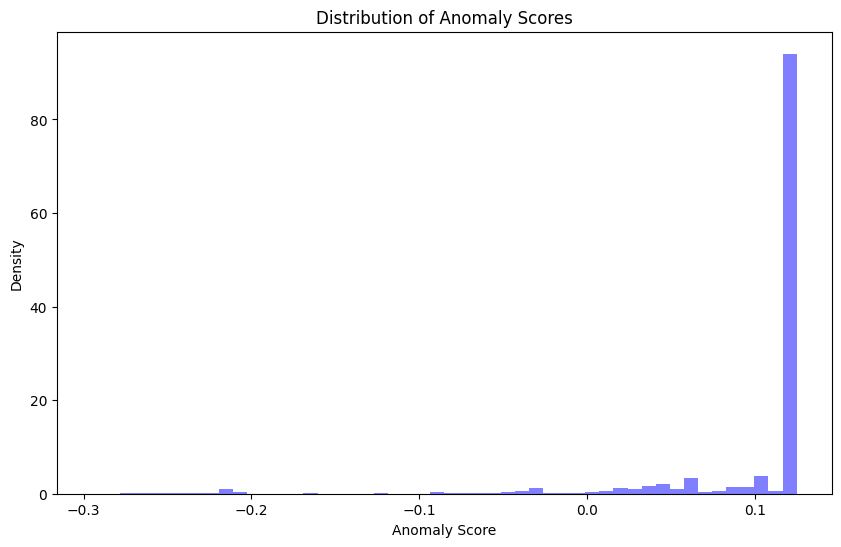

In [6]:
plt.figure(figsize=(10, 6))
plt.hist(anomaly_scores, bins=50, density=True, alpha=0.5, color='blue')
plt.xlabel('Anomaly Score')
plt.ylabel('Density')
plt.title('Distribution of Anomaly Scores')
plt.show()

Identify anomalies based on a threshold 

In [7]:
anomaly_threshold = -0.1
anomalies = data[data['anomaly_score'] < anomaly_threshold]

In [8]:
anomalies.head()

,ts,id.orig_h,id.resp_h,proto,duration,conn_state,history,orig_pkts,orig_ip_bytes,resp_pkts,label,anomaly_score
12,2018-05-09 15:30:38,192.168.100.103,10.169.219.98,tcp,2.993548,S0,S,3,180,0,Malicious,-0.122708
31,2018-05-09 15:30:49,192.168.100.103,27.135.195.214,tcp,0.998710,S0,S,2,120,0,Malicious,-0.163857
83,2018-05-09 15:31:22,192.168.100.103,218.249.159.92,tcp,0.456510,REJ,Sr,1,60,1,Malicious,-0.203310
123,2018-05-09 15:30:43,192.168.100.103,147.231.100.5,udp,0.001239,SF,Dd,1,76,1,Benign,-0.213596
191,2018-05-09 15:31:08,192.168.100.103,89.221.214.130,udp,0.003737,SF,Dd,1,76,1,Benign,-0.215644


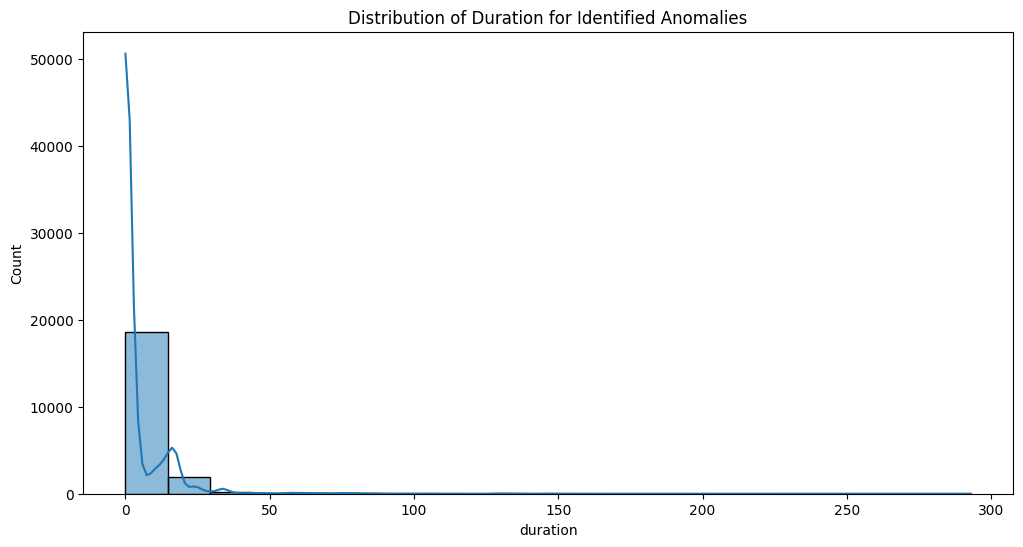

In [9]:
plt.figure(figsize=(12, 6))
sns.histplot(data=anomalies, x='duration', bins=20, kde=True)
plt.title('Distribution of Duration for Identified Anomalies')
plt.show()

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_curve, auc

In [11]:
X_train, X_test = train_test_split(data_scaled, test_size=0.2, random_state=42)


In [12]:
# Train the model on the training set
model.fit(X_train)

IsolationForest(contamination=0.05)

In [13]:
# Predict on the testing set
test_anomaly_scores = model.decision_function(X_test)

In [14]:

# Evaluate performance
anomaly_threshold = -0.1
y_test_true = (test_anomaly_scores < anomaly_threshold).astype(int)

In [15]:
# Confusion Matrix
cm = confusion_matrix(y_test_true, (test_anomaly_scores < anomaly_threshold).astype(int))


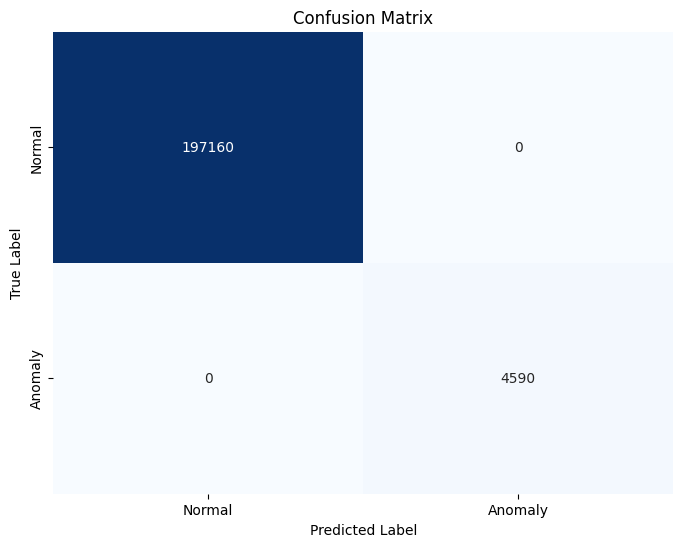

In [101]:
# Visualize Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['Normal', 'Anomaly'], yticklabels=['Normal', 'Anomaly'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

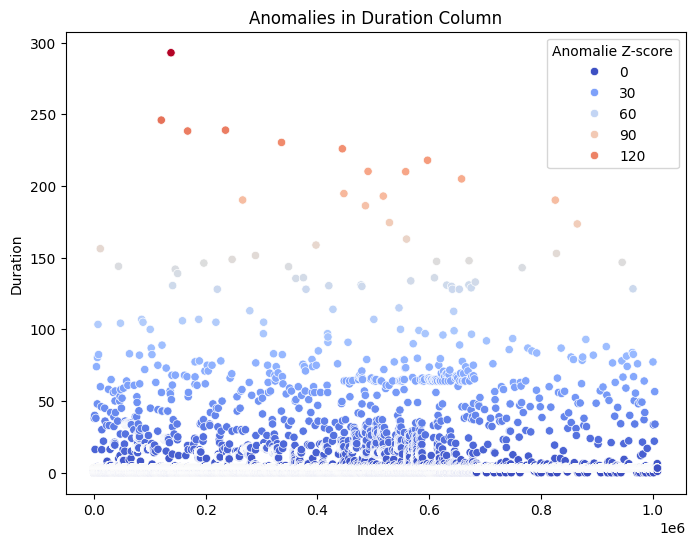

Rows with anomalies:
                          ts        id.orig_h        id.resp_h proto   
835      2018-05-09 15:34:24    192.168.100.1  192.168.100.103  icmp  \
1553     2018-05-09 15:38:47    192.168.100.1  192.168.100.103  icmp   
2250     2018-05-09 15:44:22  192.168.100.103    219.243.27.65   tcp   
3666     2018-05-09 15:51:47    192.168.100.1  192.168.100.103  icmp   
4726     2018-05-09 15:57:41    192.168.100.1  192.168.100.103  icmp   
...                      ...              ...              ...   ...   
1000695  2018-05-14 06:25:03    192.168.100.1  192.168.100.103  icmp   
1001467  2018-05-14 06:31:19    192.168.100.1  192.168.100.103  icmp   
1003041  2018-05-14 06:42:47    192.168.100.1  192.168.100.103  icmp   
1003811  2018-05-14 06:47:49    192.168.100.1  192.168.100.103  icmp   
1004324  2018-05-14 06:51:52    192.168.100.1  192.168.100.103  icmp   

          duration conn_state  history  orig_pkts  orig_ip_bytes  resp_pkts   
835      38.010023        OTH      

In [120]:
# Calculate Z-scores for the 'duration' column
data['duration_zscore'] = zscore(data['duration'])

# Define a threshold for identifying anomalies (e.g., Z-score greater than 3 or less than -3)
outlier_threshold = 3

# Identify anomalies based on the threshold
anomalies = data[abs(data['duration_zscore']) > outlier_threshold]

# Visualize anomalies in a scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=data.index, y='duration', hue='duration_zscore', data=data, palette='coolwarm')
plt.title('Anomalies in Duration Column')
plt.xlabel('Index')
plt.ylabel('Duration')
plt.legend(title='Anomalie Z-score', loc='upper right')
plt.show()

# Display the rows with anomablies
print("Rows with anomalies:")
print(anomalies[['ts', 'id.orig_h', 'id.resp_h', 'proto', 'duration', 'conn_state', 'history', 'orig_pkts', 'orig_ip_bytes', 'resp_pkts', 'label']])

In [123]:
data['ts'] = pd.to_datetime(data['ts'])
# Calculate the number of days since the minimum date
data['Days_Since_Min_Date'] = (data['ts'] - data['ts'].min()).dt.days

# Calculate Z-scores
data['Z_Score'] = np.abs((data['Days_Since_Min_Date'] - data['Days_Since_Min_Date'].mean()) / data['Days_Since_Min_Date'].std())

threshold = 3
outliers_z = data[data['Z_Score'] > threshold]
print("Outliers identified by Z-Score method:")
print(outliers_z)

Outliers identified by Z-Score method:
Empty DataFrame
Columns: [ts, id.orig_h, id.resp_h, proto, duration, conn_state, history, orig_pkts, orig_ip_bytes, resp_pkts, label, anomaly_score, duration_zscore, Days_Since_Min_Date, Z_Score]
Index: []


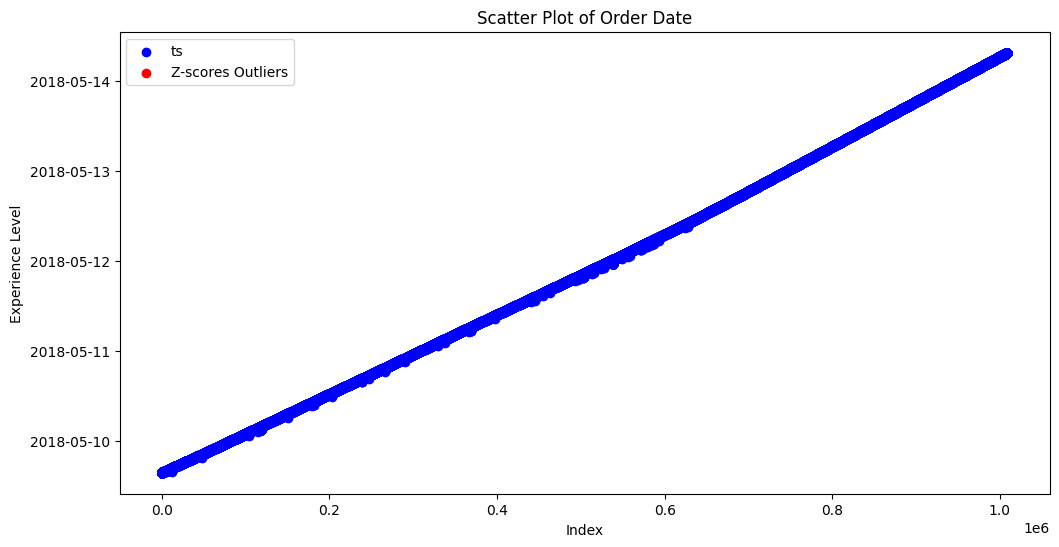

In [124]:
plt.figure(figsize=(12, 6))
plt.scatter(data.index, data['ts'], color='blue', label='ts')

# Scatter plot for outliers
plt.scatter(outliers_z.index, outliers_z['ts'], color='red', label='Z-scores Outliers')
plt.title("Scatter Plot of Order Date")
plt.xlabel("Index")
plt.ylabel("Experience Level")
plt.legend()
plt.show()

## Similarity and Dissimilarity

In [16]:
correlation = data['duration'].corr(data['orig_pkts'])
print(f"Correlation between duration and packets send from the source: {correlation}")

Correlation between duration and packets send from the source: 0.3229063027920208


Cosine similarity 

In [132]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

column1_vector = data['duration'].values.reshape(1, -1)
column2_vector = data['orig_pkts'].values.reshape(1, -1)

cosine_sim = cosine_similarity(column1_vector, column2_vector)
print(f"Cosine Similarity between duration and orig_pkts: {cosine_sim[0][0]}")


Cosine Similarity between duration and orig_pkts: 0.6844726699379442


In [133]:
from scipy.spatial.distance import euclidean

euclidean_distance = euclidean(data['duration'], data['orig_pkts'])
print(f"Euclidean Distance between duration and orig_pkts: {euclidean_distance}")


Euclidean Distance between duration and orig_pkts: 2754.0479890311653


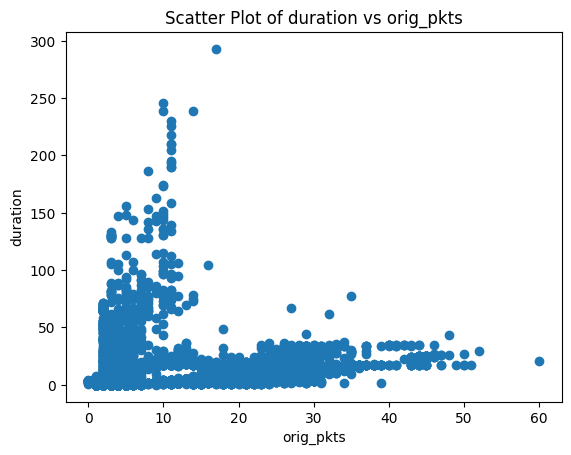

In [135]:
plt.scatter(data['orig_pkts'], data['duration'])
plt.title('Scatter Plot of duration vs orig_pkts')
plt.xlabel('orig_pkts')
plt.ylabel('duration')
plt.show()

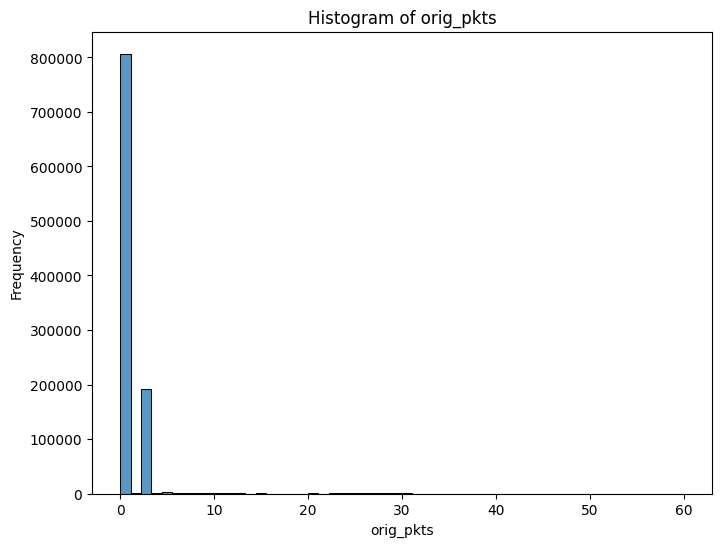

Mode:
0    1
Name: orig_pkts, dtype: int64

Percentiles:
count    1.008748e+06
mean     1.496242e+00
std      1.741176e+00
min      0.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      6.000000e+01
Name: orig_pkts, dtype: float64


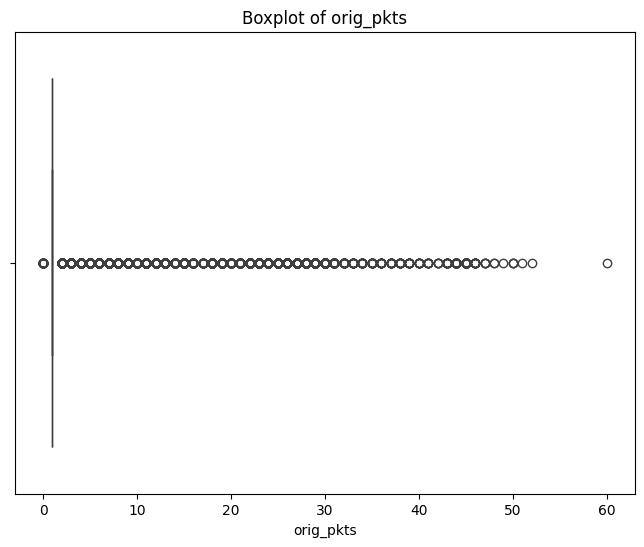

Mean: 1.4962418760681557
Median: 1.0
Range: 60
Variance: 3.031692538319493


In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def Statistics(value, name):
 # Frequency and Mode
    frequency = value.value_counts()
    mode = value.mode()

    # Visualize using histplot for frequency
    plt.figure(figsize=(8, 6))
    sns.histplot(value, bins=len(frequency), kde=False)
    plt.title(f'Histogram of {name}')
    plt.xlabel(name)
    plt.ylabel('Frequency')
    plt.show()
    print(f"Mode:\n{mode}")

    # Percentiles
    percentiles = value.describe(percentiles=[.25, .5, .75])

    print(f"\nPercentiles:\n{percentiles}")

    # Visualize using boxplot for percentiles
    plt.figure(figsize=(8, 6))
    sns.boxplot(x=value)
    plt.title(f'Boxplot of {name}')
    plt.show()

    # Mean
    mean_value = value.mean()
    print(f"Mean: {mean_value}")

    # Median
    median_value = value.median()
    print(f"Median: {median_value}")

    # Range
    range_value = value.max() - value.min()
    print(f"Range: {range_value}")

    # Variance
    variance_value = value.var()
    print(f"Variance: {variance_value}")



 

# Example Usage
Statistics(data['orig_pkts'], 'orig_pkts')
# Statistics(data['duration'], 'duration')
# Statistics(data['id.orig_h'], 'id.orig_h')
# Statistics(data['id.resp_h'], 'id.resp_h')





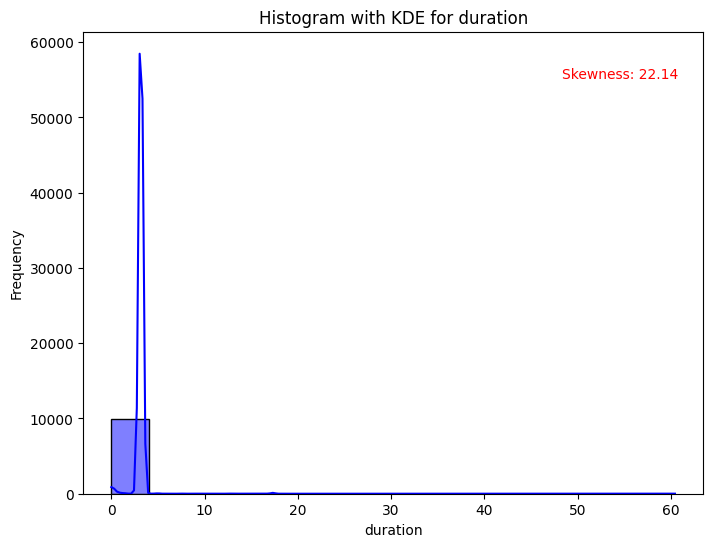

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

column_name = 'duration'

plt.figure(figsize=(8, 6))
sns.histplot(data[column_name], kde=True, color='blue')

# Add labels and title
plt.title(f'Histogram with KDE for {column_name}')
plt.xlabel(column_name)
plt.ylabel('Frequency')

# Show skewness value on the plot
skewness = data[column_name].skew()
plt.text(data[column_name].max() * 0.8, plt.ylim()[1] * 0.9, f'Skewness: {skewness:.2f}', fontsize=10, color='red')

# Show the plot
plt.show()
